<a href="https://colab.research.google.com/github/plthiyagu/Personnel/blob/master/Image_Classification_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

import os
import numpy as np

import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')

In [5]:
datasets,info= tfds.load(name='beans',with_info=True,as_supervised=True,split=['train','test','validation'])

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete7Y291P/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete7Y291P/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete7Y291P/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.
',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://gi

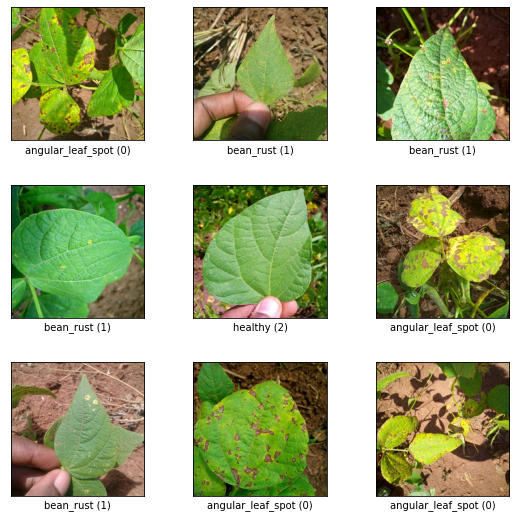

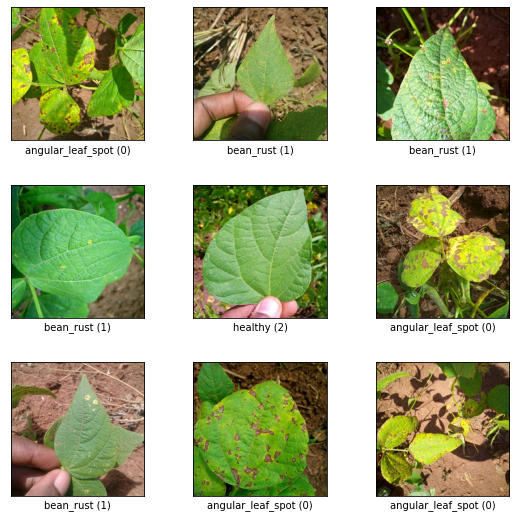

In [7]:
train, info_train = tfds.load(name='beans',with_info=True,split='test')
tfds.show_examples(info_train,train)

In [8]:
def scale(image,label):
  image=tf.cast(image,tf.float32)
  image /= 255.0

  return tf.image.resize(image,[224,224]),tf.one_hot(label,3)

In [11]:
def get_dataset(batch_size=32):
  train_dataset_scaled = datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_dataset_scaled = datasets[1].map(scale).batch(batch_size)
  val_dataset_scaled = datasets[2].map(scale).batch(batch_size)
  return train_dataset_scaled,test_dataset_scaled,val_dataset_scaled

In [12]:
train_dataset,test_dataset,val_dataset= get_dataset()
train_dataset.cache()
val_dataset.cache()

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [13]:
len(list(datasets[0]))

1034

In [14]:
feature_extractor="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [15]:
feature_extractor_layer= hub.KerasLayer(feature_extractor,input_shape=(224,224,3))

In [16]:
feature_extractor_layer.trainable=False

In [17]:
model= tf.keras.Sequential([
                            feature_extractor_layer,
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(3,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [19]:
history = model.fit(train_dataset,epochs=6,validation_data=val_dataset)

Epoch 1/6
33/33 [==============================] - 3s 90ms/step - loss: 0.9424 - acc: 0.6093 - val_loss: 0.8261 - val_acc: 0.7218
Epoch 2/6
33/33 [==============================] - 2s 51ms/step - loss: 0.8015 - acc: 0.7621 - val_loss: 0.7470 - val_acc: 0.8120
Epoch 3/6
33/33 [==============================] - 2s 53ms/step - loss: 0.7478 - acc: 0.8308 - val_loss: 0.7238 - val_acc: 0.8496
Epoch 4/6
33/33 [==============================] - 2s 54ms/step - loss: 0.7269 - acc: 0.8366 - val_loss: 0.7193 - val_acc: 0.8647
Epoch 5/6
33/33 [==============================] - 2s 53ms/step - loss: 0.7142 - acc: 0.8559 - val_loss: 0.6976 - val_acc: 0.8647
Epoch 6/6
33/33 [==============================] - 2s 52ms/step - loss: 0.6943 - acc: 0.8781 - val_loss: 0.6900 - val_acc: 0.8797


In [20]:
result= model.evaluate(test_dataset)

4/4 [==============================] - 0s 77ms/step - loss: 0.6922 - acc: 0.8906


[[0.03996063 0.6975481  0.26249123]]


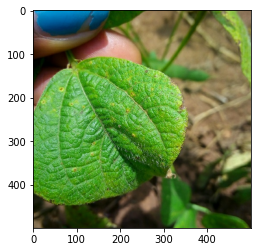

Actual Label bean_rust
Predictated Label bean_rust


In [23]:
for test_sample in datasets[1].take(10):
  image,label = test_sample[0],test_sample[1]
  image_scaled,label_arr= scale(test_sample[0],test_sample[1])
  image_scaled = np.expand_dims(image_scaled,axis=0)


img= tf.keras.preprocessing.image.img_to_array(image)
pred = model.predict(image_scaled)
print(pred)
plt.figure()
plt.imshow(image)
plt.show()
print("Actual Label %s" % info.features["label"].names[label.numpy()])
print("Predictated Label %s" % info.features["label"].names[np.argmax(pred)])

In [27]:
for f0,f1 in datasets[1].map(scale).batch(200):
  y=np.argmax(f1,axis=1)
  y_pred= np.argmax(model.predict(f0),axis=1)
  print(tf.math.confusion_matrix(labels=y,predictions=y_pred,num_classes=3))

tf.Tensor(
[[40  3  0]
 [ 8 33  2]
 [ 0  1 41]], shape=(3, 3), dtype=int32)
